<img align="center" width="12%" style="padding-right:10px;" src="Images/Ccom.png">

# Tools for Ocean Mapping <a href="https://teams.microsoft.com/l/channel/19%3anLW3JzlSiEQLpIBtk3QaOqLYRlRECyjhkUkC3WH1qKM1%40thread.tacv2/General?groupId=e05e4f0f-c653-4060-854e-6a776126d431&tenantId=d6241893-512d-46dc-8d2b-be47e25f5666"><img src="Images/help.png"  title="Ask questions on Teams" align="right" width="10%" alt="Teams.com"></a><br><br> Lab 8: Filtering Data



***

# Creation of a Heave Filter

The goal of this lab is to familiarize you with some very simple filtering techniques, and introduce you to terms such as low-pass, high pass filters, etcetera. You probably have heard of the terms before and may have some vague conceptual understanding of them.

The aim of the lab is then to extract heave information from positioning data and compare that to the heave as observed by an <ins>M</ins>otion <ins>R</ins>eference <ins>U</ins>nit (MRU or INS). In the end you should be more familiar with both the concept of heave, as well as the basics of filtering.

***

In [3]:
%load_ext autoreload
%autoreload 2

import sys
import os
import numpy as np
from mycode.motion import Motion
from mycode.position import Position
import matplotlib.pyplot as plt
abs_path=os.path.abspath(os.path.curdir)+"/Data/"


***

## Overview


### The Data

<img align="left" width="100%" style="padding-right:10px; padding-top:10px;" src="Images/usns-henson.png"><br>

The data provided here are the same data that we used in Lab 7. We will process the data with the same classes that we already created, updating them as necessary.

Opening motion data file:/home/jupyter-semmed/ESCI_872/Data/Lab_A_MRU.txt
Drawing Motion Data


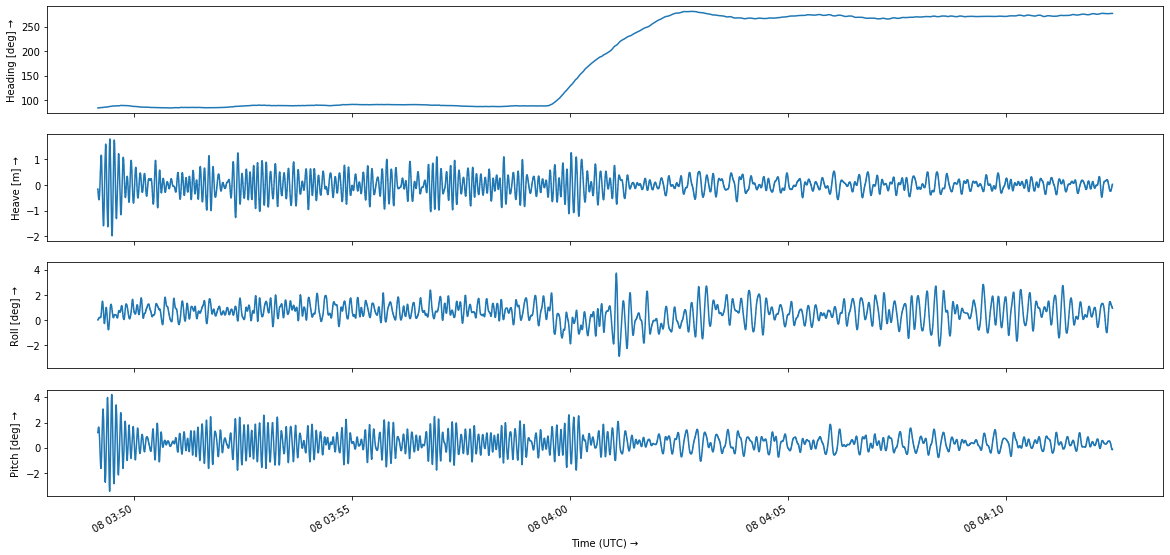

In [4]:
motions = Motion()
motions.read_jhc_file(abs_path+"Lab_A_MRU.txt")
motions.draw()

***

<img align="left" width="6%" style="padding-right:10px;" src="./Images/info.png"> 
## Lab Implementation in Python

This lab assumes a basic familiarity with Python at the level reached upon completion of the ePOM [**Programming Basics with Python for Ocean Mapping**](../python_basics) and [**Foundations of Ocean Data Science**](../ocean_data_science) sets of notebooks.

If you are already well versed in programming with Python you are free to move through the steps ahead of when they are assigned.

As part of the labs in this course you will be developing Python classes that may be used in other courses as well.

The goal is not too develop the most elegant and/or efficient code possible, but to have you write code that helps you achieve the learning objectives of the labs.

___

<img align="left" width="6%" style="padding-right:10px;" src="./Images/key.png"> 
Note that you are free to design your own code in Python or another language. If you decide to do so you have to demonstrate ***equivalency*** of the deliverables. Also, we will be happy to support any coding questions for those following the (Python) instructions provided here, but can not provide the same level of service for those using different algorithms and/or programming languages.

***

# 8 What is Heave?

Modern <ins>I</ins>nertial <ins>N</ins>avigation <ins>S</ins>ystems (INS) provide the rotational data in the form of Euler angles and/or quaternions, horizontal positioning data, and vertical positioning data. The vertical positioning data consists of elevation data (ellipsoidal and/or orthometric height) and an estimate of heave. The question is then: what is heave?
    
Depths published in chart are relative to a [**<ins>C</ins>hart <ins>D</ins>atum** (CD)](https://tidesandcurrents.noaa.gov/datum_options.html). Historically a tidal datum was established by observing water level at a set of **water level gages** (more commonly known as **tide gages**) and deriving a statistical representation of an average water level at a certain tidal phase. Typically a value well below the geometric mean of the entire observed time series is used to ensure that actual depths rarely are smaller than depths shown in the chart.

During a survey the local deviation of the current water level from chart datum then consists of the combined effects of tides, loading effects such as air pressure and winds, water density changes due to salinity and temperature changes, and local departures due to sea state. Many of these effects may be compensated for by installing a water level gage in the proximity of the survey area and assuming that the effects are strongly correlated and thus systemic. The compensation is then achieved by observing the water level deviations from CD at the gage and modeling how they relate to water level changes at the survey locale. However, water level variation due to sea state is a very small scale process and cannot be assumed to be represented by the observations at a water level gage even when it is relatively nearby. Thus, variations of the depths observations due to sea state would act as random noise in the depth measurements if not compensated for. This random noise is then known as **heave**. 

Estimation of heave is historically difficult as it needs to be observed in-situ. In order to measure the heave as a deviation from the local average water level absent sea state effect we first need to establish that level. Here an example of a manner in which this can be done:

1. observe vertical accelerations
    1. Subtract the local gravity acceleration to estimate proper acceleration
    1. Estimate an average over a long enough period to reliably predict the mean gravity acceleration associated to the mean water level, but not so long that other systematic effects that we are already compensating for get taken into account.
    1. Obtain the difference between the average and the instantaneous values, the resulting acceleration anomalies are then due to vertical motion
    1. integrate the vertical motion integration twice to determine the heave
    
<img align="center" width="60%" style="padding-right:10px;" src="./Images/sfv.png"><br>
    
Off-course there is one major problem with this approach, which is to establish what the vertical is. This itself may be achieved by using a triad of orthogonal accelerometers and combining their output. In the absence of ofter accelerations the sum of the observed accelerations would be the gravity vector. However, the combined effects of actively steering the vessel, the sea state and other effects such as wind gusts, lead to deviation of the instantaneous **<ins>S</ins>pecific <ins>F</ins>orce <ins>V</ins>ector** (SFV) from the gravity vector, and thus the vertical. 

Since gravity acceleration is conservative it is indistinguishable from other accelerations, thus the accelerometer observe the SFV and not gravity force vector. We do expect that the long term average of the SFV does point in the direction of gravity (if not the vessel would be in trouble...). Experiment has shown that for most applications and localities that when a vessel does not undergo accelerations due to navigational input (steering a turn, slowing down or speeding up) an averaging period of 120 seconds suffices. This implies that a survey vessel should run lines in a straight line, and only start acquiring data once it has been on-line for 120 seconds. This requirement clearly limits the efficiency of surveys and also restricts the areas in which surveys can safely be performed.

An effective way of estimating significant portion of non gravity accelerations is by **aiding**; aiding consists of taking input from other devices such as a positioning system or compasses to allow the modeling of accelerations due to changes in course and speed of the vessel. Theoretically the more aiding input is provided the better the results will be. However, practice has shown that under most circumstances the input of data from a dual antenna GNSS system will suffice for even the highest uncertainty requirements. Note that GNSS positioning for aiding should generally be with dual antennas so that we can accurately observe the position behavior of the antennas with respect to each-other and cancel out the common errors.


***
<img align="left" width="6%" style="padding-right:10px;" src="./Images/key.png">

When using an MRU *without* the benefit of aiding sensors the vessel *needs to move in straight lines* to minimize centripetal accelerations leading to systematic offsets in the SFV and thus systematic effects in the observed heave (and pitch and roll!). The vessel needs to come on line for at least the duration of the filter window before starting the acquisition of data - this leads to **significant** operational constraints affecting the effectiveness of the survey. This is particularly true in areas of strong bathymetric variance and/or limited maneuverability 

# 8.1 Measuring Heave Using a Positioning System

With the advent of **<ins>G</ins>lobal <ins>L</ins>avigation <ins>S</ins>atellite <ins>S</ins>ystems** (**GNSS**) we can now also establish good orthometric and/or ellipsoid height measurements. Orthometric heights are relative to the geoid, an equipotential gravity surface that closely resembles **<ins>M</ins>ean <ins>S</ins>ea <ins>L</ins>evel** (**MSL**). The method described previously starts of by establishing a gravity vector and a mean surface that is orthogonal to the direction of the gravity, which by definition means that this is an equipotential gravity surface; thus heave is measured in the same direction as orthometric heights. As a result we can measure heave if we can measure orthometric height, an ability that GNSS provides us with. 

In this lab we will estimate the heave from positioning data and compare this to the observed heave from the INS system. You will see that data match closely, but that the uncertainty of the heave obtained from GNSS observations alone is greater than that of the heave estimates that come from the combined IMU and GNSS solution provided by the INS. 

***
<img align="left" width="6%" style="padding-right:10px;" src="./Images/info.png">

It should be pointed out here that the ability to measure height to a ellipsoid datum allows us to map the the ship's 3D reference frame to a 3D Georeferenced ellipsoid frame, and express depths relative to the ellipsoid datum. If the transformation between the ellipsoid and CD we can map the observed depths straight to CD without the need to make water level corrections, including the effects of heave. GNSS gives us this capability, which has lead to a paradigm shift in how we use vertical positioning data at sea


# Step 8.2: Extracting Height Data 

The first step that we want to do is to extract the orthometric height observations from the positioning data. In Lab 7 we updated the Positiong class to read the data provided by the USNS Henson. Create a `Position` object name `positions` and read the USNS Henson data provided.

In [5]:
positions = Position()
positions.read_jhc_file(abs_path+'/Lab_A_GNSS.txt')
print('Heights relative to: ' + positions.metadata['height_relative_to'])

Opening GNSS data file:/home/jupyter-semmed/ESCI_872/Data//Lab_A_GNSS.txt
Heights relative to: geoid


As you can see from the above the heights are given relative to the geoid i.e., they are suitable to extract heave data from.

___
<img align="left" width="6%" style="padding-right:10px;" src="./Images/info.png">
In the case where orthometric heights are not available we may use ellipsoidal data instead. Due to the fact that the surface normal of the geoid and ellipsoid are not coincident this will introduce error, but at a level significantly smaller than the measurement noise in the elevation observations


*** 
To get a feel for the data lets plot the ortometric heights.

Opening GNSS data file:/home/jupyter-semmed/ESCI_872/Data//Lab_A_GNSS.txt


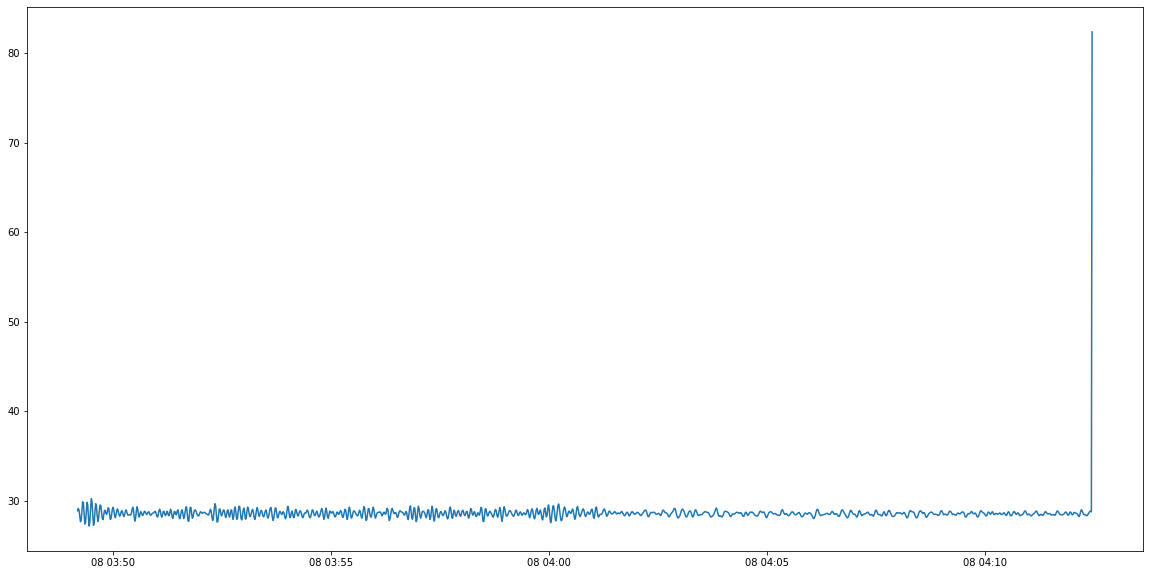

In [6]:
positions = Position()
positions.read_jhc_file(abs_path+'/Lab_A_GNSS.txt')
fig = plt.figure(figsize=(20, 10))
ax1 = plt.subplot(1,1,1)
ax1.plot(positions.times,positions.heights)
plt.show()

As you can see the heights vary around a value a little less than 30 meters, it is hard to interpret as there is a significant artifact. We can simply remove this artifact by ignoring the last observation:

Opening GNSS data file:/home/jupyter-semmed/ESCI_872/Data//Lab_A_GNSS.txt


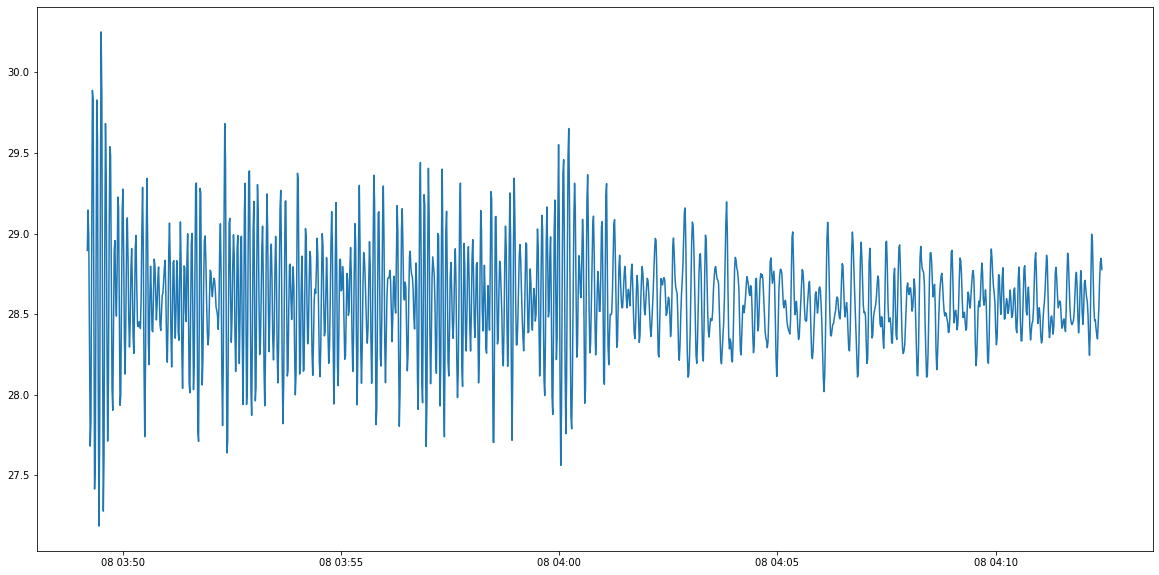

In [7]:
positions = Position()
positions.read_jhc_file(abs_path+'/Lab_A_GNSS.txt')
fig = plt.figure(figsize=(20, 10))
ax1 = plt.subplot(1,1,1)
ax1.plot(positions.times[:-1],positions.heights[:-1])
plt.show()

Though this was effective and makes it significantly easier to interpret the data it is less than satisfactory - we would like the ability to remove the outlier automatically.

The other thing that stands out is that the data is not uniform in appearance, it seems that there are some short term trends that are underlying the observed data. One of the things that we could do is to try to filter the data. We could do this in the time domain - the domain in which the data are given, or in the frequency domain to see whether there are cyclical processes at play.

Let us do the simplest thing possible and establish the mean and median

Opening GNSS data file:/home/jupyter-semmed/ESCI_872/Data//Lab_A_GNSS.txt


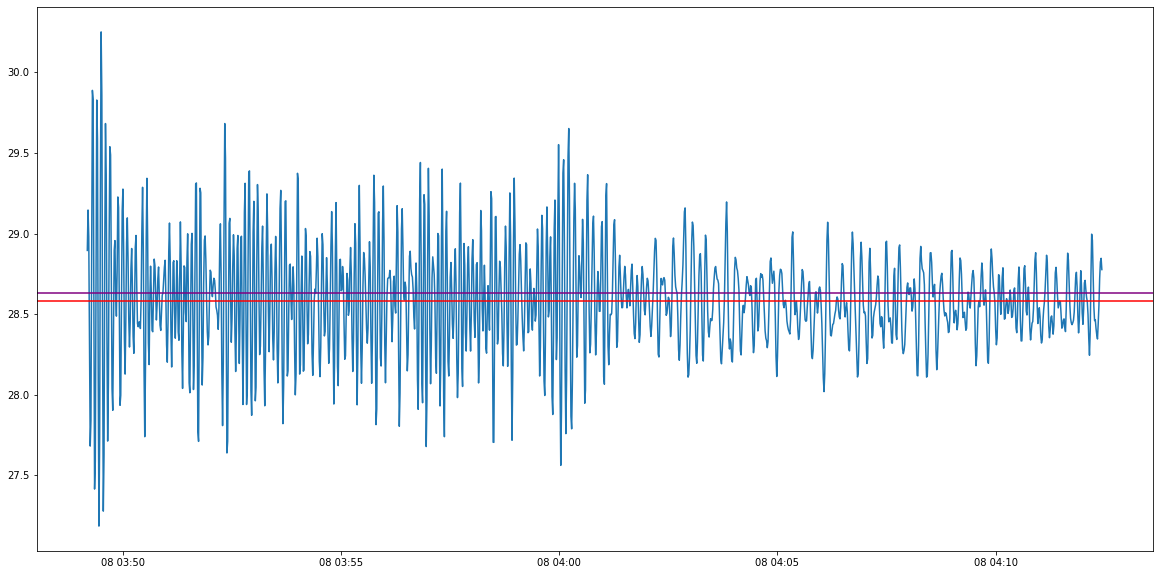

In [8]:
positions = Position()
positions.read_jhc_file(abs_path+'/Lab_A_GNSS.txt')
mean = np.mean(positions.heights)
median =  np.median(positions.heights)
fig = plt.figure(figsize=(20, 10))
ax1 = plt.subplot(1,1,1)
ax1.plot(positions.times[:-1],positions.heights[:-1])
ax1.axhline(mean,color='purple')
ax1.axhline(median,color='red')
plt.show()

## 8.3 Filtering the Height Data

Looking at this it appears that the median gives a better representation of the overall data than the mean. The reason that the mean is quite significantly offset from the mean is that in their calculation the artifact was not removed. The mean is more strongly affected by the presence and/or absence of artifacts than the median i.e., the median is a more **robust** statistic than the mean.

However, representing the data merely by the mean would certainly not do it justice, we could extract more information if we had a rolling mean (or median for that matter) that would not take the mean over the entire data set but only a small subset in the area of interest. Obtaining a rolling mean is the equivalent of sliding a, in this case, time window over the data and obtaining a mean of that window. In mathematics such an operation is known as a **convolution**. 

In the case of a running mean we simply take all the observed values, multiply them by the **coefficient** one and divide the outcome by the sum of the coefficients. Why this talk of coefficients? This seems like an overly complicated way of describing the process. The reason is that we could use different coefficients for the different observations in the filtering window, the collection of these coefficients is then known as the convolution kernel.

In our case we want to establish a convolution kernel that equally weighs all the observations. Note that if we make sure that the sum of the coefficients is one we do not have to post-multiply by the sum of the coefficients i.e., for a rolling mean the kernel is $(1/N, 1/N, ... , 1/n)$. Using `numpy` we can achieve this by using:

    np.ones(N)/N
    
To then calculate the running mean i.e., apply the convolution kernel to all the data we can use the `numpy.convolve` method, which simply applies the kernel repeatedly to the data, moving it over one sample every time.
***
<img align="left" width="6%" style="padding-right:10px;" src="./Images/info.png">
Mathematically the convolution operator is $\circledast$ is defined as follows:

$$(a\circledast k)[n] = \sum_{m=-\infty}^{\infty}a[m]k[n-m]$$

$a$: first input array
$k$: second input array

In our case the second array is our coefficient kernel
***




Opening GNSS data file:/home/jupyter-semmed/ESCI_872/Data//Lab_A_GNSS.txt


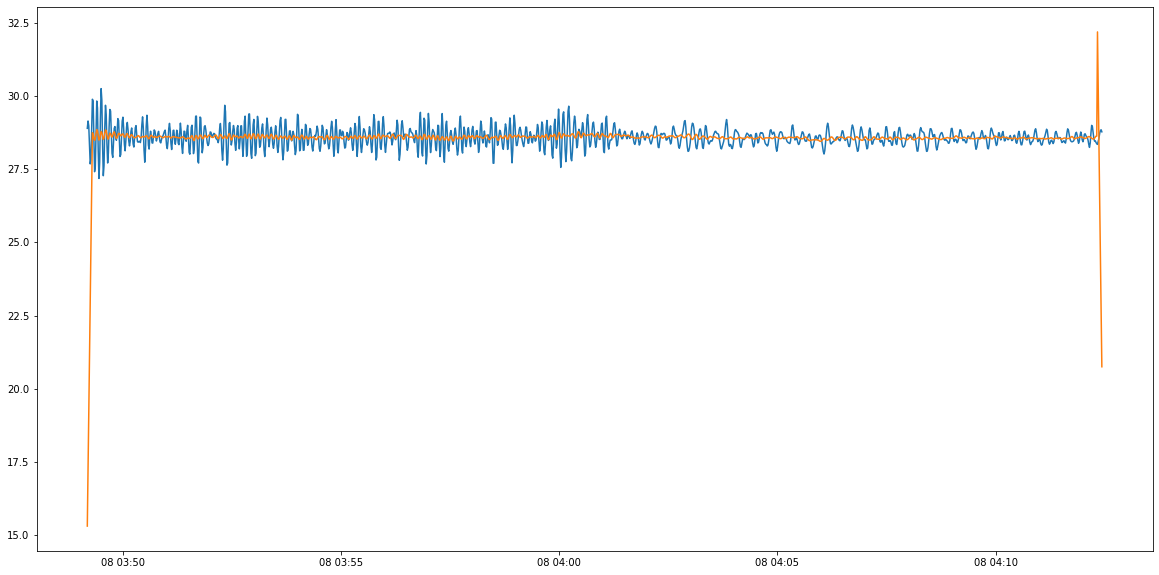

In [9]:
positions = Position()
positions.read_jhc_file(abs_path+'/Lab_A_GNSS.txt')

# Create the convolution kernels
running_mean_kernel_15s = np.ones(15)/15

# Calculate the running mean by convolving the kernels with the data
running_mean_15s = np.convolve(positions.heights,running_mean_kernel_15s,mode='same')

# Plot the results
fig = plt.figure(figsize=(20, 10))
ax1 = plt.subplot(1,1,1)
ax1.plot(positions.times[:-1],positions.heights[:-1])
ax1.plot(positions.times[:-1],running_mean_15s[:-1])
plt.show()

Egad! What happened? We see that the running mean mostly follows the data nicely, but that at either end the data deviates significantly from the raw data. The reason for this is that the kernel started at the first sample i.e., only half the window has valid data, similarly, towards the end the filter window is only partly filled with valid data. 

There are a couple of ways to deal with this, the first is to just accept the fact that the start and end of the data are ill defined and not use them, or we can extrapolate the raw data on either end and pad the array with the extrapolated values. What the best approach is depends on your application, in our case we will just ignore the start and end bits.

Opening GNSS data file:/home/jupyter-semmed/ESCI_872/Data//Lab_A_GNSS.txt


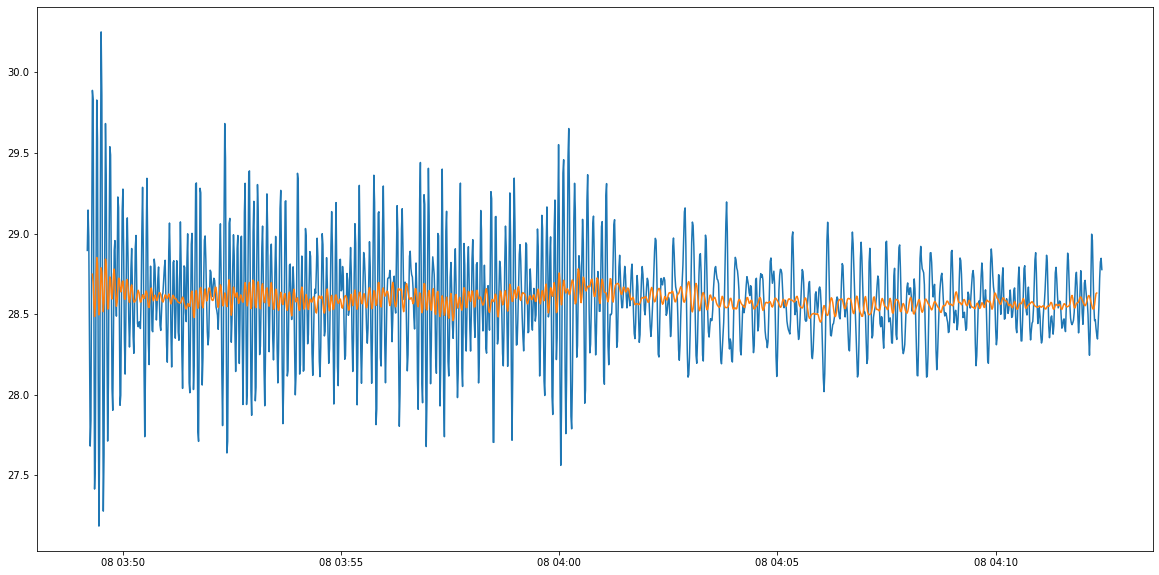

In [10]:
positions = Position()
positions.read_jhc_file(abs_path+'/Lab_A_GNSS.txt')

# Set the window size in samples
n_window = 15

# Create the convolution kernel
running_mean_kernel_15s = np.ones(n_window)/n_window

# Calculate the running mean by convolving the kernels with the data
running_mean_15s = np.convolve(positions.heights,running_mean_kernel_15s,mode='same')

# Determine the number of samples to ignore in the filtering
ignore_samples = n_window//2

# Plot the results
fig = plt.figure(figsize=(20, 10))
ax1 = plt.subplot(1,1,1)
ax1.plot(positions.times[:-1], positions.heights[:-1])
ax1.plot(positions.times[ignore_samples:-ignore_samples-1],
         running_mean_15s[ignore_samples:-ignore_samples-1])

plt.show()

***
### 8.3.1 Setting the Kernel Size

We can manipulate the filter kernel in myriad ways. We will not do this, lest we devolve into a **<ins>D</ins>igital <ins>S</ins>ignal <ins>P</ins>rocessing** course (pardon the admittedly bad pun). However, it is worthwhile to show at least the effect of the length of the filtering window here

Opening GNSS data file:/home/jupyter-semmed/ESCI_872/Data//Lab_A_GNSS.txt


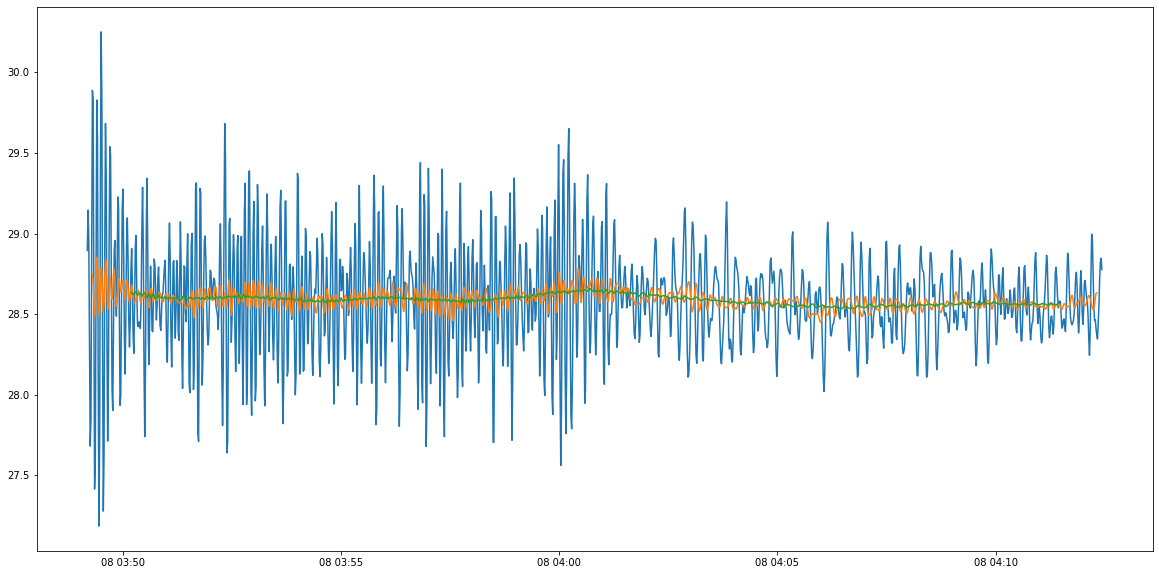

In [11]:
positions = Position()
positions.read_jhc_file(abs_path+'/Lab_A_GNSS.txt')

# Set the window size in samples
n_window_1 = 15
n_window_2 = 120

# Create the convolution kernel
running_mean_kernel_1 = np.ones(n_window_1)/n_window_1
running_mean_kernel_2 = np.ones(n_window_2)/n_window_2

# Calculate the running mean by convolving the kernels with the data
running_mean_1 = np.convolve(positions.heights,running_mean_kernel_1,mode='same')
running_mean_2 = np.convolve(positions.heights,running_mean_kernel_2,mode='same')

# Determine the number of samples to ignore in the filtering
ignore_samples_1 = n_window_1//2
ignore_samples_2 = n_window_2//2

# Plot the results
fig = plt.figure(figsize=(20, 10))
ax1 = plt.subplot(1,1,1)
ax1.plot(positions.times[:-1], positions.heights[:-1])
ax1.plot(positions.times[ignore_samples_1:-ignore_samples_1-1],
         running_mean_1[ignore_samples_1:-ignore_samples_1-1])
ax1.plot(positions.times[ignore_samples_2:-ignore_samples_2-1],
         running_mean_2[ignore_samples_2:-ignore_samples_2-1])
plt.show()

***
### 8.3.2 Extracting the Heave through Filtering

In the plot above you see the raw observed orthometric height data in blue, the rolling mean of a 15 second kernel in orange, and finally the rolling mean of a 120 second kernel in green. As you can see the longer window results in stronger filtering of the high frequency variations that may be observed in the raw data. A rolling mean filter therefore acts as a **low-pass** filter i.e., it lets low frequency signals through while suppressing high frequency components.

In the introduction (section 8) it was mentioned that if we filter over a 120 second period that we typically eliminate the sea state effects. Thus if we want to extract the heave from the GNSS orthometric height data we should take the subtract the 120 second low pass filtered data

Opening GNSS data file:/home/jupyter-semmed/ESCI_872/Data//Lab_A_GNSS.txt


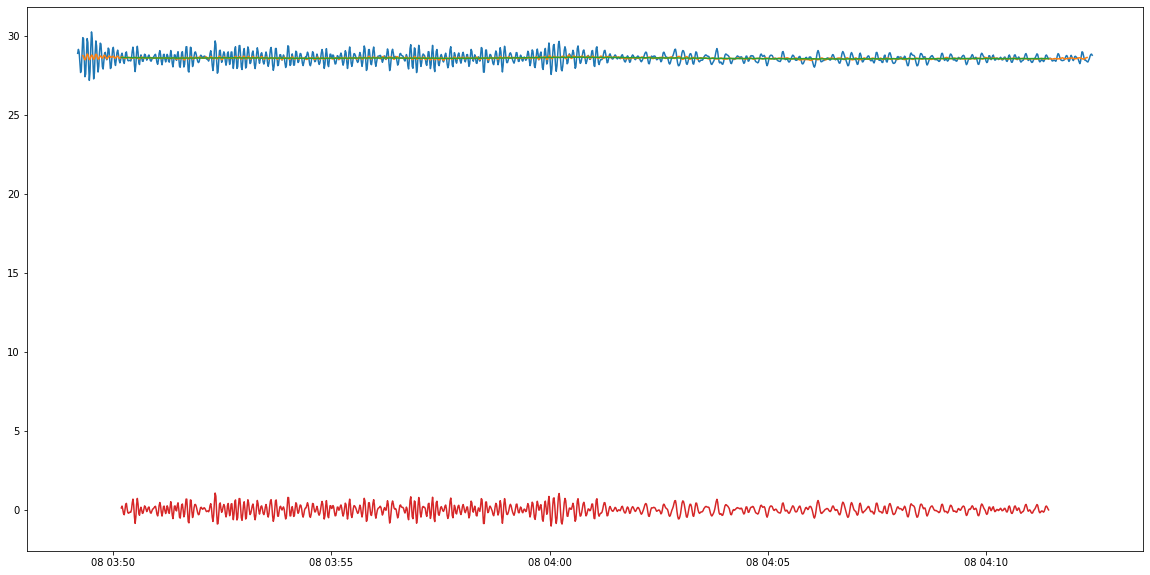

In [12]:
positions = Position()
positions.read_jhc_file(abs_path+'/Lab_A_GNSS.txt')

# Set the window size in samples
n_window = 120

# Create the convolution kernel
running_mean_kernel = np.ones(n_window_1)/n_window_1

# Calculate the running mean by convolving the kernels with the data
running_mean = np.convolve(positions.heights,running_mean_kernel,mode='same')

# Determine the number of samples to ignore in the filtering
ignore_samples = n_window//2

# Determine the heave by high pass filtering the data aka, subtracting the 
# low pass filtered data from the raw data.

heave = positions.heights - running_mean

# Plot the results
fig = plt.figure(figsize=(20, 10))
ax1 = plt.subplot(1,1,1)
ax1.plot(positions.times[:-1], positions.heights[:-1])
ax1.plot(positions.times[ignore_samples_1:-ignore_samples_1-1],
         running_mean_1[ignore_samples_1:-ignore_samples_1-1])
ax1.plot(positions.times[ignore_samples_2:-ignore_samples_2-1],
         running_mean_2[ignore_samples_2:-ignore_samples_2-1])
ax1.plot(positions.times[ignore_samples_2:-ignore_samples_2-1],
         heave[ignore_samples_2:-ignore_samples_2-1])
plt.show()

The signal in red is the heave! As you can see all the high frequency is preserved and all the trends that we could observe in the low-pass filtered have been removed, including the infinitely long signal defined by the mean of the data.

Opening GNSS data file:/home/jupyter-semmed/ESCI_872/Data//Lab_A_GNSS.txt


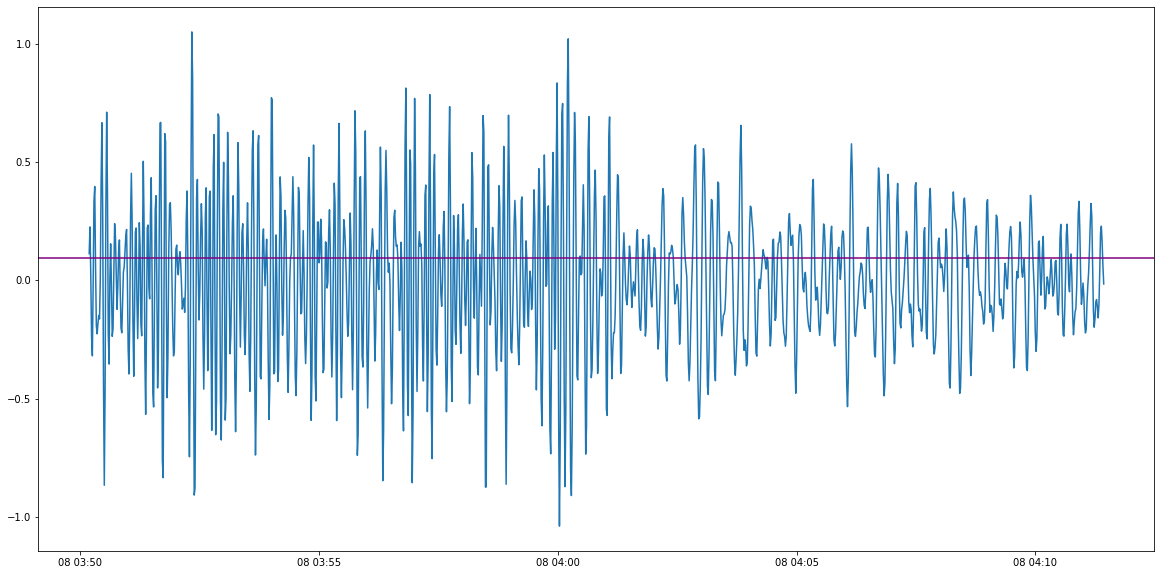

In [13]:
positions = Position()
positions.read_jhc_file(abs_path+'/Lab_A_GNSS.txt')

# Set the window size in samples
n_window = 120

# Create the convolution kernel
running_mean_kernel = np.ones(n_window_1)/n_window_1

# Calculate the running mean by convolving the kernels with the data
running_mean = np.convolve(positions.heights,running_mean_kernel,mode='same')

# Determine the number of samples to ignore in the filtering
ignore_samples = n_window//2

# Determine the heave by high pass filtering the data aka, subtracting the 
# low pass filtered data from the raw data.

heave = positions.heights - running_mean
mean_heave = np.mean(heave)

fig = plt.figure(figsize=(20, 10))
ax1 = plt.subplot(1,1,1)
ax1.plot(positions.times[ignore_samples_2:-ignore_samples_2-1],
         heave[ignore_samples_2:-ignore_samples_2-1])
ax1.axhline(mean_heave,color='purple')
plt.show()

***
### 8.3.3 Comparing the results Graphically

As you can see from the code cell above the mean of the high pass filtered data is close to zero, as is expected. If we did everything right this heave data that we have extracted should closely resemble the heave data obtained from the heave sensor. Let's compare the two:

Opening GNSS data file:/home/jupyter-semmed/ESCI_872/Data//Lab_A_GNSS.txt
Opening motion data file:/home/jupyter-semmed/ESCI_872/Data//Lab_A_MRU.txt


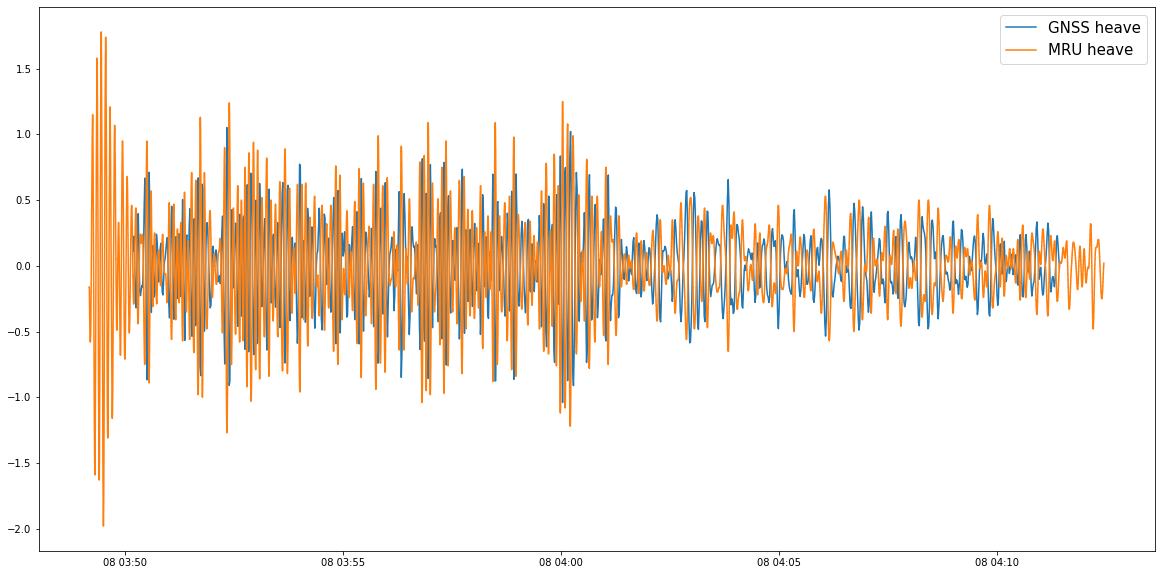

In [14]:
positions = Position()
positions.read_jhc_file(abs_path+'/Lab_A_GNSS.txt')
motions = Motion()
motions.read_jhc_file(abs_path+'/Lab_A_MRU.txt')


# Set the window size in samples
n_window = 120

# Create the convolution kernel
running_mean_kernel = np.ones(n_window_1)/n_window_1

# Calculate the running mean by convolving the kernels with the data
running_mean = np.convolve(positions.heights,running_mean_kernel,mode='same')

# Determine the number of samples to ignore in the filtering
ignore_samples = n_window//2

# Determine the heave by high pass filtering the data aka, subtracting the 
# low pass filtered data from the raw data.
heave = positions.heights - running_mean


fig = plt.figure(figsize=(20, 10))
ax1 = plt.subplot(1,1,1)
ax1.plot(positions.times[ignore_samples_2:-ignore_samples_2-1],
         heave[ignore_samples_2:-ignore_samples_2-1], label = "GNSS heave")
ax1.plot(motions.times,motions.heave, label = "MRU heave")
ax1.legend(fontsize = 15)
plt.show()

At first sight this all makes sense. Plotting these data was easy as they share a common time base and all the samples have an epoch time associated to them. The time associated to both time series is synchronized thus the heave time-series from both the INS and GNSS line up well; or do they?

Opening GNSS data file:/home/jupyter-semmed/ESCI_872/Data//Lab_A_GNSS.txt
Opening motion data file:/home/jupyter-semmed/ESCI_872/Data//Lab_A_MRU.txt


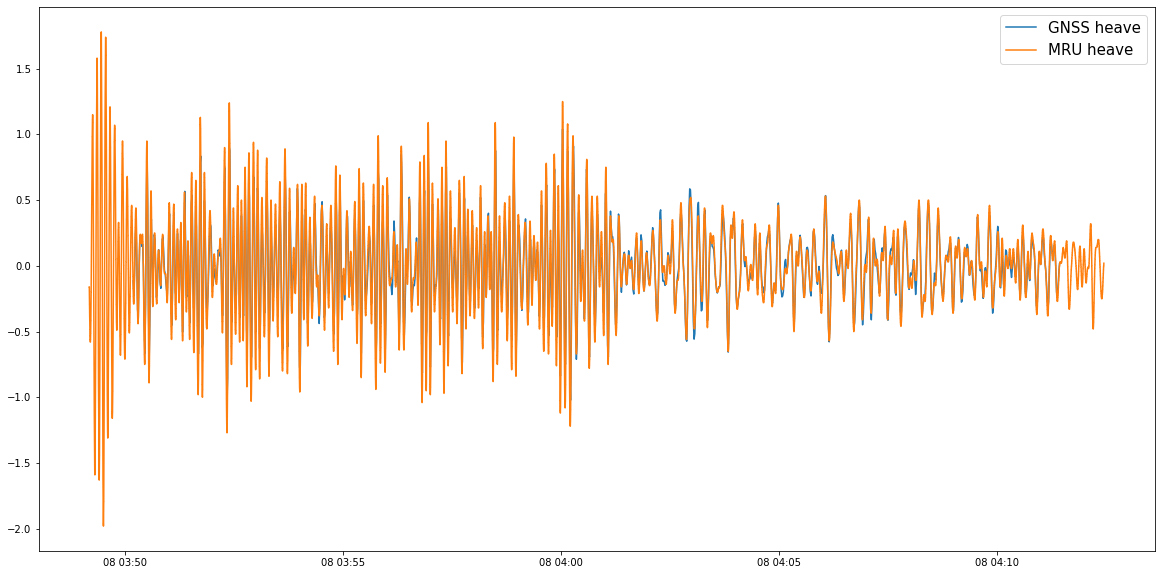

In [15]:
positions = Position()
positions.read_jhc_file(abs_path+'/Lab_A_GNSS.txt')
motions = Motion()
motions.read_jhc_file(abs_path+'/Lab_A_MRU.txt')


# Set the window size in samples
n_window = 120

# Create the convolution kernel
running_mean_kernel = np.ones(n_window_1)/n_window_1

# Calculate the running mean by convolving the kernels with the data
running_mean = np.convolve(positions.heights,running_mean_kernel,mode='same')

# Determine the number of samples to ignore in the filtering
ignore_samples = n_window//2

# Determine the heave by high pass filtering the data aka, subtracting the 
# low pass filtered data from the raw data.
heave = positions.heights - running_mean


fig = plt.figure(figsize=(20, 10))
ax1 = plt.subplot(1,1,1)
ax1.plot(positions.times[ignore_samples_2:-ignore_samples_2-1],
         -heave[ignore_samples_2:-ignore_samples_2-1], label = "GNSS heave")
ax1.plot(motions.times,motions.heave, label = "MRU heave")
ax1.legend(fontsize = 15)
plt.show()

The match between the data in the plots is significantly better; I achieved this by adding a single character to the code, namely the minus sign. Remember our discussion about reference frames. The motion data provided by the INS is given with the positive Z-axis in the down direction, thus to match our GNSS estimated heave we have to reflect the z-values.

***
### 8.3.4 Comparing the results Quantitatively

Though from the plotting we have reasonable trust that the heave from the GNSS matches the heave from the motion sensor fairly well it should be pointed out that the GNSS derived heave is at a much lower time resolution than the INS heave(1Hz vs 100Hz update rate). This is hidden from view by the graphs due to the fact that the data points are connected by lines.

Note that to compare the heave time series they need to be on the same basis and have samples at the same epochs. The first requirement is met as both are reported to POSIX time and synchronized to the same clock. However the 2<sup>nd</sup> requirement is not as the devices sample independently. This results in the requirement to resample one of the time series to match the other. In our case it makes sense to resample the INS time series as it is sampled at a high much higher rate and thus interpolation needs to be done over much smaller time spans.

Opening GNSS data file:/home/jupyter-semmed/ESCI_872/Data//Lab_A_GNSS.txt
Opening motion data file:/home/jupyter-semmed/ESCI_872/Data//Lab_A_MRU.txt


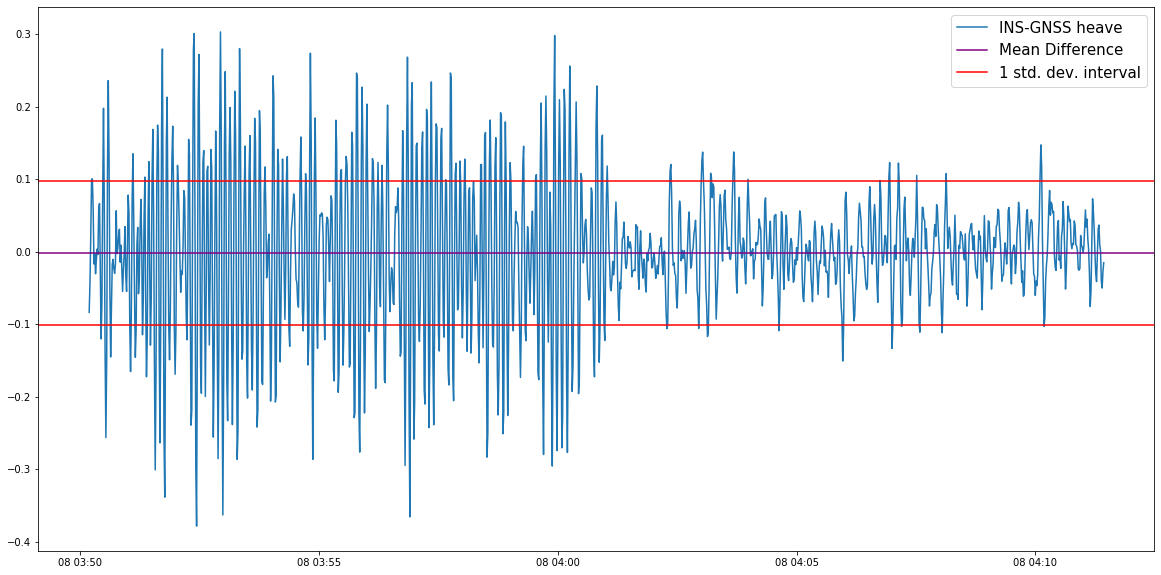

In [38]:
positions = Position()
positions.read_jhc_file(abs_path+'/Lab_A_GNSS.txt')
motions = Motion()
motions.read_jhc_file(abs_path+'/Lab_A_MRU.txt')

# Set the window size in samples
n_window = 120

# Create the convolution kernel
running_mean_kernel = np.ones(n_window_1)/n_window_1

# Calculate the running mean by convolving the kernels with the data
running_mean = np.convolve(positions.heights,running_mean_kernel,mode='same')

# Determine the number of samples to ignore in the filtering
ignore_samples = n_window//2

# Determine the heave by high pass filtering the data aka, subtracting the 
# low pass filtered data from the raw data.
heave_gns = positions.heights - running_mean

# Determine the heave from the INS at the same epochs by resampling

gps_times = np.array([e.timestamp() for e in positions.times])
ins_times = np.array([e.timestamp() for e in motions.times])

ins_heave = np.interp(gps_times, ins_times, motions.heave)


fig = plt.figure(figsize=(20, 10))
ax1 = plt.subplot(1,1,1)
ax1.plot(positions.times[ignore_samples_2:-ignore_samples_2-1],
         ins_heave[ignore_samples_2:-ignore_samples_2-1]+heave[ignore_samples_2:-ignore_samples_2-1], label = "INS-GNSS heave")

mean = np.mean(ins_heave[ignore_samples_2:-ignore_samples_2-1]+heave[ignore_samples_2:-ignore_samples_2-1])
stdev = np.std(ins_heave[ignore_samples_2:-ignore_samples_2-1]+heave[ignore_samples_2:-ignore_samples_2-1])
ax1.axhline(mean,color='purple', label = 'Mean Difference')
ax1.axhline(mean+stdev,color='red', label = '1 std. dev. interval')
ax1.axhline(mean-stdev,color='red')
ax1.legend(fontsize = 15)
plt.show()


As can be seen from the above the mean of the differences between the heave from the INS and the GNSS is zero i.e., there is no bias. However, the standard deviation is about 10cm and the difference ranges by about 70cm. Let's see how this compares to the heave uncertainty for the INS as reported by the manufacturer.

Opening GNSS data file:/home/jupyter-semmed/ESCI_872/Data//Lab_A_GNSS.txt
Opening motion data file:/home/jupyter-semmed/ESCI_872/Data//Lab_A_MRU.txt


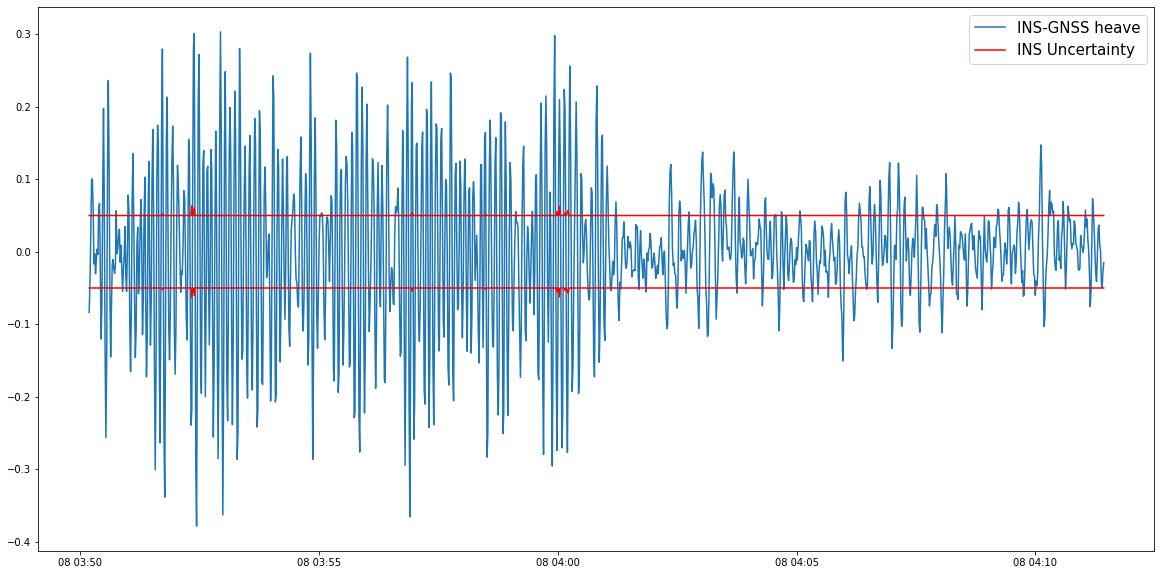

In [60]:
positions = Position()
positions.read_jhc_file(abs_path+'/Lab_A_GNSS.txt')
motions = Motion()
motions.read_jhc_file(abs_path+'/Lab_A_MRU.txt')

# Set the window size in samples
n_window = 120

# Create the convolution kernel
running_mean_kernel = np.ones(n_window_1)/n_window_1

# Calculate the running mean by convolving the kernels with the data
running_mean = np.convolve(positions.heights,running_mean_kernel,mode='same')

# Determine the number of samples to ignore in the filtering
ignore_samples = n_window//2

# Determine the heave by high pass filtering the data aka, subtracting the 
# low pass filtered data from the raw data.
heave_gns = positions.heights - running_mean

# Determine the heave from the INS at the same epochs by resampling

gps_times = np.array([e.timestamp() for e in positions.times])
ins_times = np.array([e.timestamp() for e in motions.times])

ins_heave = np.interp(gps_times, ins_times, motions.heave)

# The manufacturer claimed uncertainty
ins_uncertainty = np.array([abs(.05*h) for h in ins_heave])
i = 0
for u in ins_uncertainty:
    if u < 0.05:
        ins_uncertainty[i] = 0.05
    i += 1


fig = plt.figure(figsize=(20, 10))
ax1 = plt.subplot(1,1,1)
ax1.plot(positions.times[ignore_samples_2:-ignore_samples_2-1],
         ins_heave[ignore_samples_2:-ignore_samples_2-1]+heave[ignore_samples_2:-ignore_samples_2-1], label = "INS-GNSS heave")
ax1.plot(positions.times[ignore_samples_2:-ignore_samples_2-1],
         ins_uncertainty[ignore_samples_2:-ignore_samples_2-1],color='red', label = "INS Uncertainty")
ax1.plot(positions.times[ignore_samples_2:-ignore_samples_2-1],
         -ins_uncertainty[ignore_samples_2:-ignore_samples_2-1],color='red')

ax1.legend(fontsize = 15)
plt.show()


The manufactures specification for the Applanix POSMV 320 is that the expected uncertainty is the greater of 5cm or 5% of the observed heave. The orange line in the plot above shows this uncertainty versus the difference between the INS heave estimates and the GNSS heave estimates. It is clear that these differences far exceed the accuracy of the POSMV, thus if high accuracy is required the use of the POSMV is required.

Note that we may obtain estimates for roll and pitch in similar fashion, however the INS will much more significantly outperform the GNSS for those parameters


<img align="left" width="6%" style="padding-right:10px; padding-top:10px;" src="Images/refs.png">

## Useful References

* [The official Python 3.6 documentation](https://docs.python.org/3.6/index.html)
  * [Classes](https://docs.python.org/3.6/tutorial/classes.html)
  * [String Representation Method](https://docs.python.org/3.6/reference/datamodel.html?highlight=repr#object.__str__)
* [Memory address](https://en.wikipedia.org/wiki/Memory_address)
* [ePOM: Programming Basics with Python](https://github.com/hydroffice/python_basics)
* [ePOM: Foundations of Ocean Data Science](https://github.com/hydroffice/ocean_data_science)
* [Tilt Sensing Using a Three-Axis 
Accelerometer](https://www.nxp.com/files-static/sensors/doc/app_note/AN3461.pdf)
* [Chart Datum](https://tidesandcurrents.noaa.gov/datum_options.html)



<img align="left" width="5%" style="padding-right:10px;" src="Images/email.png">

*For issues or suggestions related to this notebook that should not be addressed on Teams, write to: semmed@ccom.unh.edu*

Python code and Notebook implementation by Semme J. Dijkstra
Data from OE/ESCI 774/874 Lab A by John Hughes Clarke